# **Example**
---
test STAN using `cmdstanpy`

In [1]:
# Load packages used in this notebook
import os
import json
import shutil
import urllib.request
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Install package CmdStanPy
!pip install --upgrade cmdstanpy

In [ ]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
tgz_file = 'colab-cmdstan-2.36.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.36.0/colab-cmdstan-2.36.0.tgz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.36.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

In [4]:
cont_zp = 700.0
cont_slope = 5.0
amplitude = 150.0
width = 0.5
center = 5.0

# Next, a grid of wavelenght channels (assumed to have no uncertainty)
wave = np.linspace(0,10,100)

# The 'true' observations
flux = amplitude*np.exp(-0.5*np.power(wave-center,2)/width**2) + \
       cont_zp + cont_slope*wave

# The actual observations = true observations + Poisson noise
obs_flux = np.random.poisson(flux)

Text(0, 0.5, 'Counts')

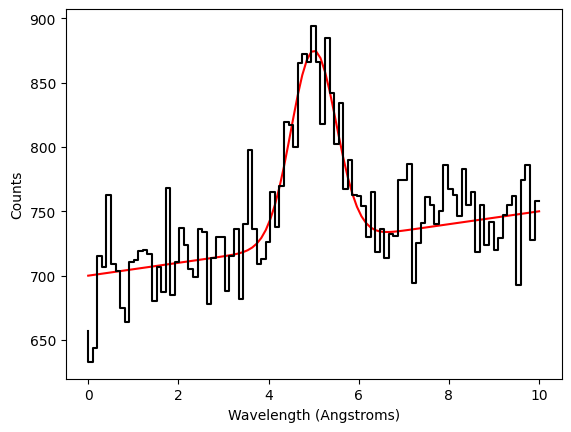

In [5]:
%matplotlib inline
from matplotlib.pyplot import subplots,plot,step,xlabel,ylabel,show,subplots
fig,ax = subplots(1,1)
ax.plot(wave, flux, 'r-')
ax.step(wave, obs_flux, color='k')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Counts')

In [6]:
model_string = '/content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example.stan'
with open(model_string, 'r') as fd:
        print('\n'.join(fd.read().splitlines()))

data {
  int <lower=1> N;      // number of data points
  vector[N] wave;       // the wavelengths
  vector[N] flux;       // the observed flux values
}

parameters {
  real<lower=-1000, upper=1000> cont;  // continuum level
  real<lower=-100, upper=100> slope;   // continuum slope
  real<lower=0, upper=1000> amp;       // amplitude of Gaussian
  real <lower=0, upper=10> center;     // center of the line
  real <lower=0, upper=10> width;      // scale
}

model {
  vector[N] mod_flux;    // the model flux

  // continuum slope + Gaussian
  mod_flux = amp*exp(-0.5*square(center - wave)/square(width)) +
             cont + slope*wave;
  // Poisson is approximately Normal with sigma = sqrt(counts)
  flux ~ normal(mod_flux, sqrt(flux));
}


In [7]:
idata = dict(N=len(wave), wave=wave, flux=obs_flux)

In [8]:
from cmdstanpy import cmdstan_path, CmdStanModel
import cmdstanpy

# Compile example
example_model = CmdStanModel(stan_file = model_string, force_compile=True)

DEBUG:cmdstanpy:Removing /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example
22:10:01 - cmdstanpy - INFO - compiling stan file /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example.stan to exe file /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example
INFO:cmdstanpy:compiling stan file /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example.stan to exe file /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=example.stan /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Compiling pre-compiled header. This might take a few seconds. ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/

In [9]:
# Condition on example data bernoulli.data.json
example_fit = example_model.sample(data = idata, seed = 123);

DEBUG:cmdstanpy:cmd: /content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9dw8t2nb/kf0uqiv7.json
22:10:51 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmp9dw8t2nb/kf0uqiv7.json', 'output', 'file=/tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example', 'id=2', 'random', 'seed=123', 'data', 'file=/tmp/tmp9dw8t2nb/kf0uqiv7.json', 'output', 'file=/tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example', 'id=3', 'random', 'seed=123', 'data', 'file=/tmp/tmp9dw8t2nb/kf0uqi

22:10:54 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/MyDrive/Github_rep/alphaxbio/stan_compute/example', 'id=1', 'random', 'seed=123', 'data', 'file=/tmp/tmp9dw8t2nb/kf0uqiv7.json', 'output', 'file=/tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_1.csv
 console_msgs (if any):
	/tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default

In [10]:
# Print a summary of the posterior sample
example_fit.summary()

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp9dw8t2nb/stansummary-example-36yk93dv.csv /tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_1.csv /tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_2.csv /tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_3.csv /tmp/tmp9dw8t2nb/exampleq14fm4af/example-20250711221051_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-33.115200,0.035851,1.541020,1.358430,-36.179100,-32.801900,-31.229900,1806.21,2558.79,1.00193
cont,694.942000,0.118750,5.500440,5.404820,686.130000,694.916000,704.303000,2190.73,2317.93,1.00077
slope,6.291480,0.019927,0.929323,0.900250,4.744240,6.309120,7.808990,2202.34,2306.21,1.00043
amp,145.954000,0.227835,12.135900,12.135800,126.071000,145.712000,166.440000,2888.65,2787.77,1.00110
center,5.063010,0.000803,0.045517,0.045931,4.988220,5.064130,5.138070,3233.04,2668.65,1.00016
width,0.514352,0.000940,0.049368,0.048012,0.437748,0.512193,0.598963,2879.87,2441.48,1.00078


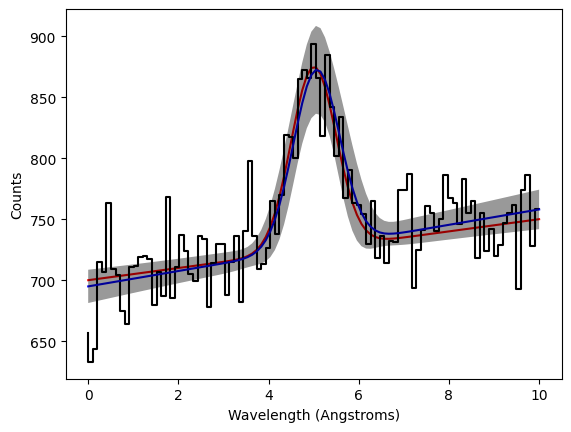

In [11]:
def Gauss(x, amp, center, width, cont, slope):
  return amp*np.exp(-0.5*np.power(x-center,2)/width**2) + cont +\
        slope*x

mamp = np.median(example_fit.stan_variable('amp'))
mcont = np.median(example_fit.stan_variable('cont'))
mslope = np.median(example_fit.stan_variable('slope'))
mcenter = np.median(example_fit.stan_variable('center'))
mwidth = np.median(example_fit.stan_variable('width'))
xx = np.linspace(wave.min(), wave.max(), 100)
yy = Gauss(xx, mamp, mcenter,mwidth,mcont, mslope)
ax.plot(xx, yy, '-', color='b')
yys = [Gauss(xx, example_fit.stan_variable('amp')[ii*10], example_fit.stan_variable('center')[ii*10],
             example_fit.stan_variable('width')[ii*10], example_fit.stan_variable('cont')[ii*10],
             example_fit.stan_variable('slope')[ii*10]) \
             for ii in range(100)]
sdy = np.std(yys, axis=0)
ax.fill_between(xx, yy-3*sdy, yy+3*sdy, facecolor='k', alpha=0.4, zorder=10)
fig